In [1]:
!pip install torch
!pip install datasets
!pip install tokenizers
!pip install torchmetrics
!pip install lightning
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.2
    Uninstalling huggingface-hub-0.17.2:
      Successfully uninstalled huggingface-hub-0.17.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00
    

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import torchvision
import torchvision.transforms as transforms

def download_and_extract_mnist_data():
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    xtrain = trainset.data.numpy()
    ytrain = trainset.targets.numpy()
    xval = testset.data[:1000].numpy()
    yval = testset.targets[:1000].numpy()

    return xtrain, ytrain, xval, yval


In [5]:
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms

def create_mnist_data_loaders(batch_size=32):
    """
    Downloads the MNIST dataset, processes it, and creates data loaders for training and testing.

    Args:
    batch_size (int): Batch size for data loaders.

    Returns:
    trainloader (torch.utils.data.DataLoader): DataLoader for training data.
    testloader (torch.utils.data.DataLoader): DataLoader for testing data.
    """
    # Download and extract MNIST data
    xtrain, ytrain, x_val_pre, y_val = download_and_extract_mnist_data()

    # Count and filter data
    count = np.zeros(10)
    idx = []
    for i in range(len(ytrain)):
        for j in range(10):
            if ytrain[i] == j:
                count[j] += 1
                if count[j] <= 1000:
                    idx = np.append(idx, i)

    y_train = ytrain[idx.astype('int')]
    x_train_pre = xtrain[idx.astype('int')]

    # Resizing the images from 28x28 to 14x14
    r, _, _ = x_train_pre.shape
    x_train = np.zeros([r, 14, 14])
    for i in range(r):
        a = cv2.resize(x_train_pre[i].astype('float32'), (14, 14))  # Resizing the image from 28*28 to 14*14
        x_train[i] = a

    r, _, _ = x_val_pre.shape
    x_val = np.zeros([r, 14, 14])
    for i in range(r):
        a = cv2.resize(x_val_pre[i].astype('float32'), (14, 14))  # Resizing the image from 28*28 to 14*14
        x_val[i] = a

    # Binarizing
    x_train = np.where(x_train > 128, 1, 0)
    x_val = np.where(x_val > 128, 1, 0)
    x_train = x_train.astype(np.float32)
    x_val = x_val.astype(np.float32)

    # Creating dataloaders
    trainset = [[x_train[i], y_train[i]] for i in range(len(y_train))]
    testset = [[x_val[i], y_val[i]] for i in range(len(y_val))]

    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=100)

    return trainloader, testloader

# Usage
trainloader, testloader = create_mnist_data_loaders()
print(trainloader)

100%|██████████| 9912422/9912422 [00:00<00:00, 93924358.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56951431.04it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26951926.91it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21238047.68it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std

    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [16]:
# Function to set up optimizer and scheduler
def setup_optimizer_and_scheduler(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'max', factor=0.5, patience=5, threshold=0.001, cooldown=0, min_lr=0.0001, verbose=True
    )
    return optimizer, scheduler

# Function to calculate the loss
def loss_function(y, x, mu, std):
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

In [20]:
def train_and_validate_vae(model, trainloader, testloader, optimizer, scheduler, num_epochs=20):
  if torch.cuda.is_available():
    model.cuda()
  count=0
  err_l, kld_l, n_wu, testl, update = [], [], [], [], []
  for epoch in range(1, 20):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

  return n_wu, err_l, kld_l



In [21]:
def plot_elbo_terms(n_wu, err_l, kld_l):
    plt.figure(figsize=(5, 3), dpi=100)
    plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
    plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
    plt.title('Plotting first and second term of ELBO')
    plt.xlabel('Number of weight updates')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Function to visualize input and output from the VAE
def visualize_vae_output(model, dataloader):
    model.eval()
    for i in range(8):
        a, t = next(iter(dataloader))
        a = a.cuda()
        recon, mu, std = model(a[0])
        b = recon[0].reshape((14, 14))
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(a[0].detach().cpu().numpy())
        axarr[1].imshow(b.detach().cpu().numpy())
        plt.show()

====> Epoch: 1 Average loss: -53.7517
====> Test set loss: -43.1433
====> Epoch: 2 Average loss: -40.7590
====> Test set loss: -38.9703
====> Epoch: 3 Average loss: -37.9776
====> Test set loss: -37.0396
====> Epoch: 4 Average loss: -36.5450
====> Test set loss: -36.1014
====> Epoch: 5 Average loss: -35.6711
====> Test set loss: -35.4042
====> Epoch: 6 Average loss: -35.0998
====> Test set loss: -34.8276
====> Epoch: 7 Average loss: -34.6168
====> Test set loss: -34.6182
====> Epoch: 8 Average loss: -34.2241
====> Test set loss: -34.2828
====> Epoch: 9 Average loss: -33.8860
====> Test set loss: -34.0567
====> Epoch: 10 Average loss: -33.6753
====> Test set loss: -33.8917
====> Epoch: 11 Average loss: -33.4221
====> Test set loss: -33.7075
====> Epoch: 12 Average loss: -33.2289
====> Test set loss: -33.4066
====> Epoch: 13 Average loss: -33.0485
====> Test set loss: -33.3274
====> Epoch: 14 Average loss: -32.8886
====> Test set loss: -33.1903
====> Epoch: 15 Average loss: -32.7429
====

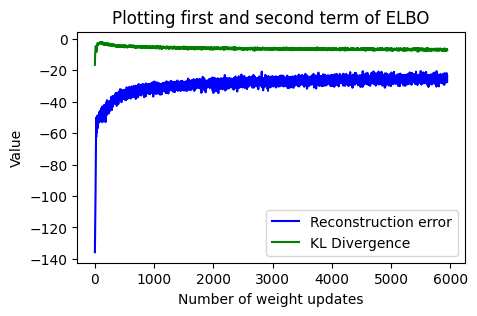

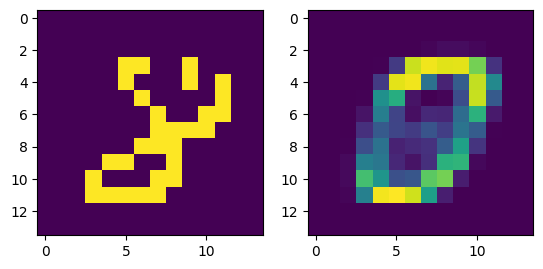

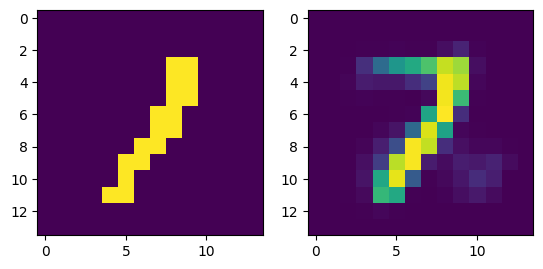

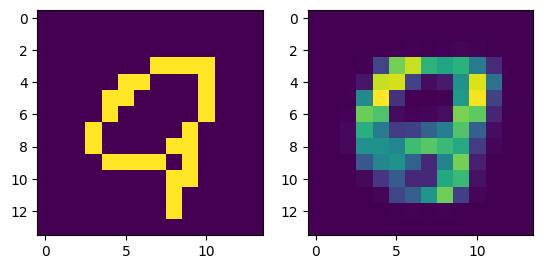

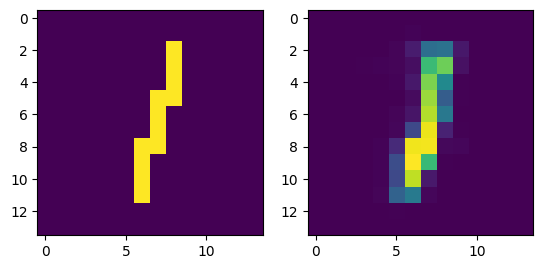

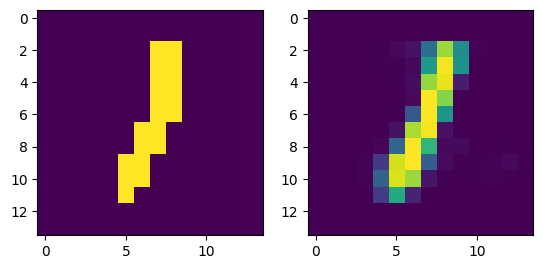

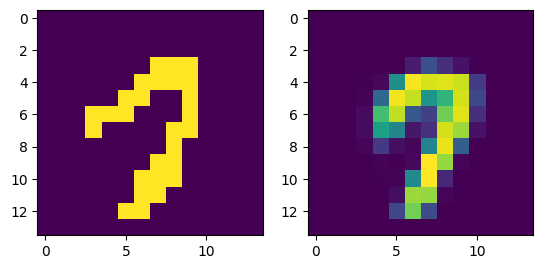

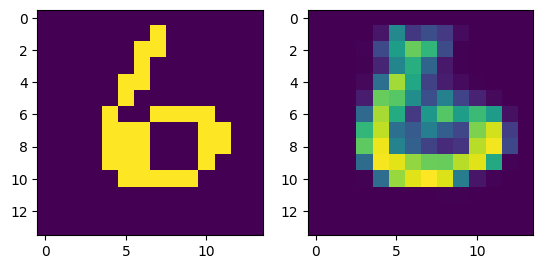

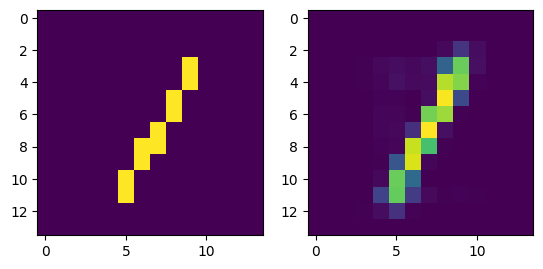

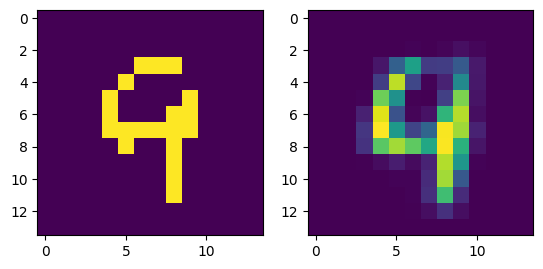

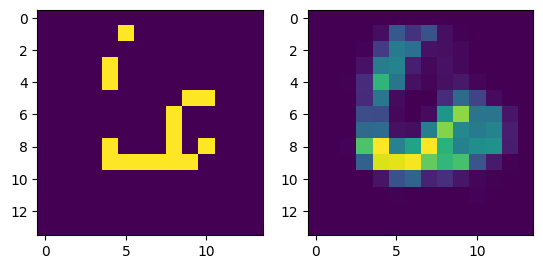

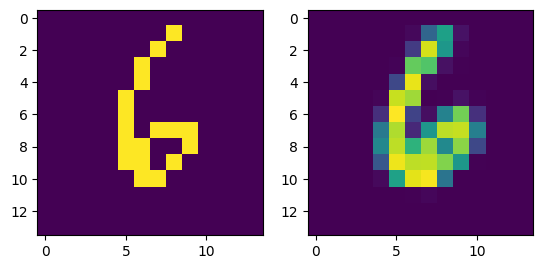

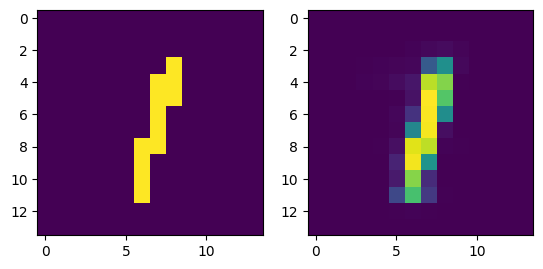

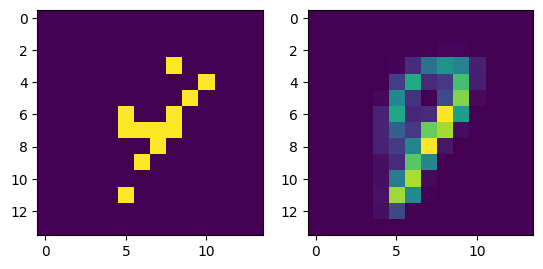

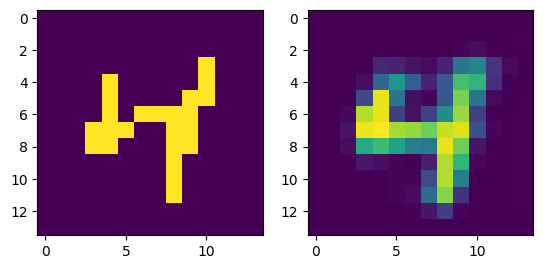

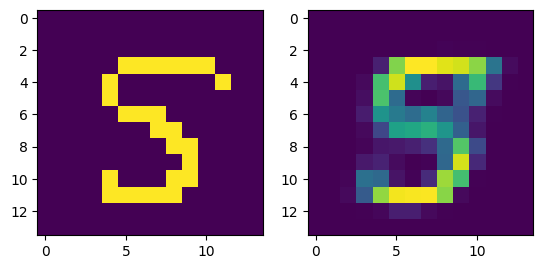

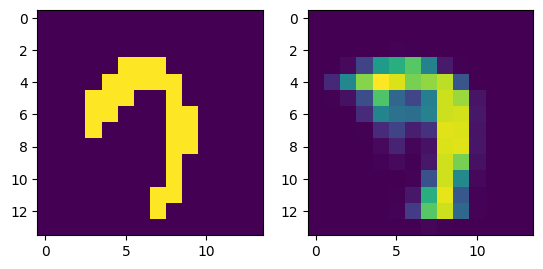

In [22]:
# Usage
# Define your VAE model
model = VAE()

# Set up optimizer and scheduler
optimizer, scheduler = setup_optimizer_and_scheduler(model)

# Train and validate the VAE
n_wu, err_l, kld_l = train_and_validate_vae(model, trainloader, testloader, optimizer, scheduler, num_epochs=20)

# Plot the ELBO terms
plot_elbo_terms(n_wu, err_l, kld_l)

# Visualize input and output from the training set
visualize_vae_output(model, trainloader)

# Visualize input and output from the validation set
visualize_vae_output(model, testloader)